## Import the Required Libraries

In [1]:
# For string manipulation and data i/o
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

# For visualization and plotting
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

## Load the Data

In this example we shall convert french(fra) to english. So loading the necessary files.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
        
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("./fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [5]:
fra_eng = fra_eng[:50000,:]

## Text Cleaning / Preprocessing

In [6]:
# Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

fra_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go', 'Marche',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go', 'Bouge ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['Tom liked what he saw', 'Tom a aimé ce quil a vu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619279 (Aiji)'],
       ['Tom liked what he saw', 'Tom aima ce quil vit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619280 (Aiji)'],
       ['Tom likes skiing too', 'Tom aussi aime skier',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2869208 (CK) & #5591397 (Aiji)']],
      dtype='<U325')

In [7]:
# convert text to lowercase
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    fra_eng[i,1] = fra_eng[i,1].lower()

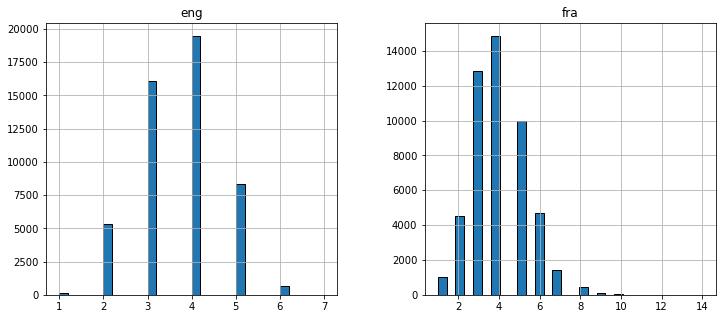

In [8]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in fra_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fra_eng[:,1]:
      fra_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

length_df.hist(bins = 30, edgecolor='k', figsize = (12,5))
plt.show()


In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(fra_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6042


In [11]:
eng_tokenizer.index_word

{1: 'i',
 2: 'you',
 3: 'a',
 4: 'is',
 5: 'tom',
 6: 'it',
 7: 'the',
 8: 'to',
 9: 'im',
 10: 'he',
 11: 'this',
 12: 'me',
 13: 'that',
 14: 'are',
 15: 'do',
 16: 'youre',
 17: 'was',
 18: 'we',
 19: 'have',
 20: 'my',
 21: 'your',
 22: 'dont',
 23: 'not',
 24: 'were',
 25: 'its',
 26: 'they',
 27: 'go',
 28: 'be',
 29: 'did',
 30: 'can',
 31: 'all',
 32: 'she',
 33: 'like',
 34: 'no',
 35: 'in',
 36: 'what',
 37: 'very',
 38: 'of',
 39: 'here',
 40: 'want',
 41: 'how',
 42: 'ill',
 43: 'on',
 44: 'thats',
 45: 'get',
 46: 'cant',
 47: 'need',
 48: 'know',
 49: 'up',
 50: 'one',
 51: 'for',
 52: 'him',
 53: 'out',
 54: 'so',
 55: 'good',
 56: 'at',
 57: 'now',
 58: 'just',
 59: 'please',
 60: 'has',
 61: 'there',
 62: 'theyre',
 63: 'too',
 64: 'love',
 65: 'help',
 66: 'come',
 67: 'us',
 68: 'why',
 69: 'got',
 70: 'look',
 71: 'who',
 72: 'hes',
 73: 'lets',
 74: 'will',
 75: 'take',
 76: 'his',
 77: 'see',
 78: 'let',
 79: 'well',
 80: 'am',
 81: 'think',
 82: 'had',
 83: 'an',

In [12]:
# prepare Francais tokenizer
fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 8
print('Francais Vocabulary Size: %d' % fra_vocab_size)

Francais Vocabulary Size: 13974


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])   
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])   

# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
trainX[:5]

array([[ 1159,    25,   627,     0,     0,     0,     0,     0],
       [ 7114,   190,  1517,     0,     0,     0,     0,     0],
       [    1,     6,    36,   199,   286,     2,     0,     0],
       [10909,     0,     0,     0,     0,     0,     0,     0],
       [   43,    29,   101,  1574,     0,     0,     0,     0]])

## Define the Model

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    # sequential model for seq2seq network
    model = Sequential()
    # add embedding layer
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    # LSTM network
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [18]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

In [19]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

## Fit the Model

In [20]:
filename = 'seq_2_seq_model'

In [21]:
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 2.9544
Epoch 1: val_loss improved from inf to 2.62529, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 609s 2s/step - loss: 2.9544 - val_loss: 2.6253
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 2.3769
Epoch 2: val_loss improved from 2.62529 to 2.27593, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 752s 3s/step - loss: 2.3769 - val_loss: 2.2759
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 2.0949
Epoch 3: val_loss improved from 2.27593 to 2.06719, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 674s 3s/step - loss: 2.0949 - val_loss: 2.0672
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.8735
Epoch 4: val_loss improved from 2.06719 to 1.91283, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 727s 3s/step - loss: 1.8735 - val_loss: 1.9128
Epoch 5/10
250/250 [==============================] - ETA: 0s - loss: 1.6939
Epoch 5: val_loss improved from 1.91283 to 1.80050, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 1331s 5s/step - loss: 1.6939 - val_loss: 1.8005
Epoch 6/10
250/250 [==============================] - ETA: 0s - loss: 1.5405
Epoch 6: val_loss improved from 1.80050 to 1.71379, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 710s 3s/step - loss: 1.5405 - val_loss: 1.7138
Epoch 7/10
250/250 [==============================] - ETA: 0s - loss: 1.4030
Epoch 7: val_loss improved from 1.71379 to 1.64631, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 681s 3s/step - loss: 1.4030 - val_loss: 1.6463
Epoch 8/10
250/250 [==============================] - ETA: 0s - loss: 1.2735
Epoch 8: val_loss improved from 1.64631 to 1.56713, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 689s 3s/step - loss: 1.2735 - val_loss: 1.5671
Epoch 9/10
250/250 [==============================] - ETA: 0s - loss: 1.1575
Epoch 9: val_loss improved from 1.56713 to 1.53185, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 777s 3s/step - loss: 1.1575 - val_loss: 1.5319
Epoch 10/10
250/250 [==============================] - ETA: 0s - loss: 1.0530
Epoch 10: val_loss improved from 1.53185 to 1.49180, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 762s 3s/step - loss: 1.0530 - val_loss: 1.4918


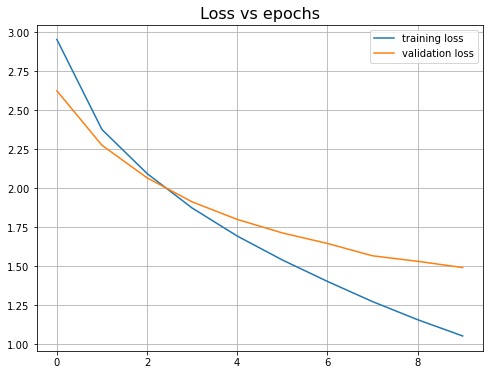

In [22]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.grid()
plt.title("Loss vs epochs",fontsize=16)
plt.show()

## Prediction on unseen data

In [23]:
model = load_model(filename)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            7154688   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 6042)           3099546   
                                                                 
Total params: 14,452,634
Trainable params: 14,452,634
Non-trainable params: 0
____________________________________________

### Generating predictions

In [25]:
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1]))[:1024,:],batch_size=128)

8/8 [==============================] - 7s 609ms/step


In [26]:
preds = preds.argmax(axis=2)

In [27]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [28]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [29]:
pred_df = pd.DataFrame({'actual' : test[:1024,0], 'predicted' : preds_text})

In [30]:
pred_df.head(10)

,actual,predicted
0,im glad to hear it,im glad to it
1,its dead,its
2,keep climbing,dont touch
3,i respect you,im will you
4,what did you do then,what you like
5,ill give you a hint,ill get you a towel
6,have they arrived yet,did they all yet
7,she knows everything,she knows everything
8,i hope its true,i hope its wrong
9,they robbed me blind,they asked me blind
